## TRAIN.PY

In [1]:
import logging
import os
from datetime import datetime, timedelta
from typing import List

import torch
from omegaconf import OmegaConf
from torch.utils.data import ConcatDataset, DataLoader
from tqdm import tqdm

from models.MiDas import MidasNet
from models.TernausNet import UNet16 

from datasets import BaseDepthDataset, DatasetMode, get_dataset
from datasets.mixed_sampler import MixedBatchSampler
from trainers.trainer import NetTrainer
from util.config_util import recursive_load_config
from util.depth_transform import (
    DepthNormalizerBase,
    get_depth_normalizer,
)
from util.logging_util import config_logging

c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
t_start = datetime.now()
print(f"start at {t_start}")
# -------------------- Arguments --------------------
class argumenty():
    def __init__(self) -> None:
        self.config = './config/test_nyu_laptop.yaml'
        self.resume_run = None
        self.output_dir = './test_files'
        self.exit_after = -1
        self.base_data_dir = "C:/Users/micha/Downloads/nyu_v2-20240826T235024Z-001"
        self.add_datetime_prefix = True
        
args = argumenty()
resume_run = args.resume_run
output_dir = args.output_dir
base_data_dir = args.base_data_dir

# -------------------- Initialization --------------------
# Resume previous run
if resume_run is not None:
    print(f"Resume run: {resume_run}")
    out_dir_run = os.path.dirname(os.path.dirname(resume_run))
    job_name = os.path.basename(out_dir_run)
    # Resume config file
    cfg = OmegaConf.load(os.path.join(out_dir_run, "config.yaml"))
else:
    # Run from start
    cfg = recursive_load_config(args.config)
    # Full job name
    pure_job_name = os.path.basename(args.config).split(".")[0]
    # Add time prefix
    if args.add_datetime_prefix:
        job_name = f"{t_start.strftime('%y_%m_%d-%H_%M_%S')}-{pure_job_name}"
    else:
        job_name = pure_job_name

    # Output dir
    if output_dir is not None:
        out_dir_run = os.path.join(output_dir, job_name)
    else:
        out_dir_run = os.path.join("./output", job_name)
    os.makedirs(out_dir_run, exist_ok=False)

# Other directories
out_dir_dic = {
    'ckpt'  : os.path.join(out_dir_run, "checkpoint"),
    'rec' : os.path.join(out_dir_run, "records"),
}
for key in out_dir_dic.keys():
    if not os.path.exists(out_dir_dic[key]):
        os.makedirs(out_dir_dic[key])

# -------------------- Logging settings --------------------
config_logging(cfg.logging, out_dir=out_dir_run)
logging.debug(f"config: {cfg}")
# -------------------- Device --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"device = {device}")

# -------------------- Snapshot of code and config --------------------
if resume_run is None:
    _output_path = os.path.join(out_dir_run, "config.yaml")
    with open(_output_path, "w+") as f:
        OmegaConf.save(config=cfg, f=f)
    logging.info(f"Config saved to {_output_path}")
    # Copy and tar code on the first run
    _temp_code_dir = os.path.join(out_dir_run, "code_tar")
    _code_snapshot_path = os.path.join(out_dir_run, "code_snapshot.tar")
    os.system(
        f"rsync --relative -arhvz --quiet --filter=':- .gitignore' --exclude '.git' . '{_temp_code_dir}'"
    )
    os.system(f"tar -cf {_code_snapshot_path} {_temp_code_dir}")
    os.system(f"rm -rf {_temp_code_dir}")
    logging.info(f"Code snapshot saved to: {_code_snapshot_path}")

# -------------------- Data --------------------
loader_seed = cfg.dataloader.seed
if loader_seed is None:
    loader_generator = None
else:
    loader_generator = torch.Generator().manual_seed(loader_seed)

# Training dataset
depth_transform: DepthNormalizerBase = get_depth_normalizer(
    cfg_normalizer=cfg.depth_normalization
)
train_dataset: BaseDepthDataset = get_dataset(
    cfg.dataset.train,
    base_data_dir=base_data_dir,
    mode=DatasetMode.TRAIN,
    augmentation_args=cfg.augmentation_args,
    depth_transform=depth_transform,
    gt_depth_type=cfg.gt_depth_type
)

if "mixed" == cfg.dataset.train.name:
    dataset_ls = train_dataset
    assert len(cfg.dataset.train.prob_ls) == len(
        dataset_ls
    ), "Lengths don't match: `prob_ls` and `dataset_list`"
    concat_dataset = ConcatDataset(dataset_ls)
    mixed_sampler = MixedBatchSampler(
        src_dataset_ls=dataset_ls,
        batch_size=cfg.dataloader.train_batch_size,
        drop_last=True,
        prob=cfg.dataset.train.prob_ls,
        shuffle=True,
        generator=loader_generator,
    )
    train_loader = DataLoader(
        concat_dataset,
        batch_sampler=mixed_sampler,
        num_workers=cfg.dataloader.num_workers,
        pin_memory=cfg.dataloader.pin_memory, 
    )
else:
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=cfg.dataloader.train_batch_size,
        num_workers=cfg.dataloader.num_workers,
        shuffle=True,
        generator=loader_generator,
        pin_memory=cfg.dataloader.pin_memory,
    )
# Validation dataset
val_dataset: BaseDepthDataset = get_dataset(
    cfg.dataset.val,
    base_data_dir=base_data_dir,
    mode=DatasetMode.EVAL,
    depth_transform=depth_transform,
    gt_depth_type=cfg.gt_depth_type
)
if "mixed" == cfg.dataset.val.name:
    dataset_ls = val_dataset
    assert len(cfg.dataset.val.prob_ls) == len(
        dataset_ls
    ), "Lengths don't match: `prob_ls` and `dataset_list`"
    concat_dataset = ConcatDataset(dataset_ls)
    mixed_sampler = MixedBatchSampler(
        src_dataset_ls=dataset_ls,
        batch_size=cfg.dataloader.val_batch_size,
        drop_last=True,
        prob=cfg.dataset.val.prob_ls,
        shuffle=False,
        generator=loader_generator,
    )
    val_loader = DataLoader(
        concat_dataset,
        batch_sampler=mixed_sampler,
        num_workers=cfg.dataloader.num_workers,
        pin_memory=cfg.dataloader.pin_memory,
    )
else:
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=cfg.dataloader.val_batch_size,
        num_workers=cfg.dataloader.num_workers,
        shuffle=False,
        generator=loader_generator,
        pin_memory=cfg.dataloader.pin_memory,
    )
# Test dataset
test_loaders: List[DataLoader] = []
for _test_dic in cfg.dataset.test:
    _test_dataset = get_dataset(
        _test_dic,
        base_data_dir=base_data_dir,
        mode=DatasetMode.EVAL,
        depth_transform=depth_transform,
        gt_depth_type=cfg.gt_depth_type
    )
    _test_loader = DataLoader(
        dataset=_test_dataset,
        batch_size=cfg.dataloader.test_batch_size,
        shuffle=False,
        num_workers=cfg.dataloader.num_workers,
        pin_memory=cfg.dataloader.pin_memory,
    )
    test_loaders.append(_test_loader)

dataloaders = {
    'train' : train_loader,
    'val' : val_loader,
    'tests' : test_loaders,
}

# -------------------- Model --------------------
if cfg.model.name == 'TernausNet':
    model = UNet16(pretrained=True, is_deconv=True)
elif cfg.model.name == 'MiDas':
  model = MidasNet(backbone=cfg.model.backbone)
else:
  raise NotImplementedError 

start at 2024-09-16 10:03:03.922559
 2024-09-16 10:03:03,962 - INFO -188212039.py - <module> >> device = cuda
 2024-09-16 10:03:03,969 - INFO -188212039.py - <module> >> Config saved to ./test_files\24_09_16-10_03_03-test_nyu_laptop\config.yaml
 2024-09-16 10:03:04,092 - INFO -188212039.py - <module> >> Code snapshot saved to: ./test_files\24_09_16-10_03_03-test_nyu_laptop\code_snapshot.tar


Using cache found in C:\Users\micha/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:

# -------------------- Trainer --------------------
# Exit time
if args.exit_after > 0:
    t_end = t_start + timedelta(minutes=args.exit_after)
    logging.info(f"Will exit at {t_end}")
else:
    t_end = None

logging.debug(f"Trainer: treiner_nets")
trainer = NetTrainer(
    cfg=cfg,
    model=model,
    dataloaders=dataloaders,
    device=device,
    out_dir_dic=out_dir_dic,
)

# -------------------- Checkpoint --------------------
if resume_run is not None:
    trainer.load_checkpoint(
        resume_run, load_trainer_state=True, resume_lr_scheduler=True
    )

# -------------------- Training & Evaluation Loop --------------------
try:
    trainer.train_and_validate(t_end=t_end)
except Exception as e:
    logging.exception(e)

 2024-09-16 07:45:42,455 - INFO -trainer.py - train_and_validate >> Start training
 2024-09-16 07:45:42,455 - INFO -trainer.py - train_and_validate >> Epoch [1/10]


  0%|          | 0/140 [00:00<?, ?it/s]c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
val: loss: 0.3413:  95%|█████████▌| 19/20 [00:40<00:02,  2.12s/it]c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torch\nn\modules\conv.py:456: 

 2024-09-16 07:52:58,709 - INFO -trainer.py - train_and_validate >> Epoch [2/10]


val: loss: 0.3469: 100%|██████████| 20/20 [00:45<00:00,  2.25s/it]


 2024-09-16 08:00:20,722 - INFO -trainer.py - train_and_validate >> Epoch [3/10]


train: loss: 0.3349:   1%|▏         | 2/140 [00:07<07:51,  3.41s/it]

: 

## CONF / DEVICE

In [14]:
from util.config_util import recursive_load_config
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

conf_path = './config/test_nyu_laptop.yaml'
cfg = recursive_load_config(conf_path)

## TEST LOADERS

In [15]:
from datasets import DatasetMode, get_dataset
from torch.utils.data import DataLoader
from util.depth_transform import (
    DepthNormalizerBase,
    get_depth_normalizer,
)

depth_transform: DepthNormalizerBase = get_depth_normalizer(
    cfg_normalizer=cfg.depth_normalization
)

test_loaders = []
for _test_dic in cfg.dataset.test:
    _test_dataset = get_dataset(
        _test_dic,
        base_data_dir='C:/Users/micha/Downloads/nyu_v2-20240826T235024Z-001',
        mode=DatasetMode.EVAL,
        gt_depth_type=cfg.gt_depth_type,
        depth_transform=depth_transform,
    )
    _test_loader = DataLoader(
        dataset=_test_dataset,
        batch_size=cfg.dataloader.test_batch_size,
        shuffle=False,
        num_workers=cfg.dataloader.num_workers,
        pin_memory=cfg.dataloader.pin_memory,
    )
    test_loaders.append(_test_loader)
    
batch = next(iter(test_loaders[0]))

## MODEL

### build

In [16]:
from models.MiDas import MidasNet
from models.TernausNet import UNet16 

if cfg.model.name == 'TernausNet':
    model = UNet16(pretrained=True, is_deconv=True)
elif cfg.model.name == 'MiDas':
  model = MidasNet(backbone=cfg.model.backbone)
else:
  raise NotImplementedError

Using cache found in C:\Users\micha/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### load

#### best

In [ ]:
import glob

path = glob.glob('./test_files/*'+conf_path.split('/')[-1].split('.')[-2]+'/checkpoint/latest/best_net.pth')
model.load_state_dict(
    torch.load(path[0], map_location=device)
)
model = model.to(device)

#### latest

In [4]:
import glob

path = glob.glob('./test_files/*'+conf_path.split('/')[-1].split('.')[-2]+'/checkpoint/latest/net.pth')
model.load_state_dict(
    torch.load(path[0], map_location=device)
)
model = model.to(device)

## WIZUALIZACJA

#### best output comp

In [17]:
model = model.to(device)

c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


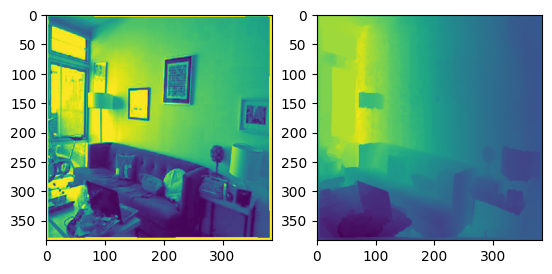

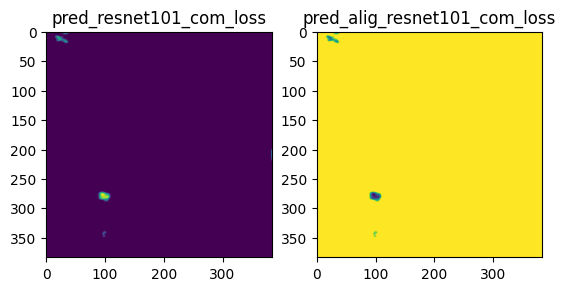

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import torch
from models.MiDas import MidasNet
from models.TernausNet import UNet16
from util.alignment import align_depth_least_square

fig, (a1,a2) = plt.subplots(1,2)
a1.imshow(batch['rgb_img'][0][0])
a2.imshow(batch['depth_raw_linear'][0][0])
    
pred = model(batch['rgb_img'][0].unsqueeze(0).to(device))
pred_a = align_depth_least_square(batch['depth_raw_linear'][0].unsqueeze(0), pred.detach().cpu(), batch['valid_mask_raw'][0].unsqueeze(0), return_scale_shift=False)

output_alig = np.clip(
    pred_a,
    a_min=test_loaders[0].dataset.min_depth,
    a_max=test_loaders[0].dataset.max_depth,
)
# clip to d > 0 for evaluation
output_alig = np.clip(output_alig, a_min=1e-6, a_max=None)

fig, (a1,a2) = plt.subplots(1,2)
a1.imshow(pred.detach().cpu().numpy()[0][0])
a1.title.set_text('pred_'+cfg.model.backbone+'_'+cfg.loss.name)
a2.imshow(output_alig[0][0])
a2.title.set_text('pred_alig_'+cfg.model.backbone+'_'+cfg.loss.name)

torch.cuda.empty_cache()

In [19]:
from util import metric

metric.delta3_acc(output_alig, batch['depth_raw_linear'][0].unsqueeze(0), batch['valid_mask_raw'][0].unsqueeze(0))

tensor(0.9912)

#### record comp

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import glob

tr_list = glob.glob('./test_files/*test_nyu_laptop*/*/train*.csv')
vl_list = glob.glob('./test_files/*test_nyu_laptop*/*/val*.csv')


tr0 = pd.read_csv(tr_list[0])


for name in tr0.columns[1:]:
    f, (a1,a2) = plt.subplots(1,2)
    f.suptitle(name)
    for i in range(len(tr_list)):
        tr = pd.read_csv(tr_list[i])
        vl = pd.read_csv(vl_list[i])
        a1.plot(tr['epoch'], tr[name], label = tr_list[i].split('\\')[-3].split('_')[7:])
        a2.plot(vl['epoch'], vl[name], label = vl_list[i].split('\\')[-3].split('_')[7:])
        a1.legend()
        a2.legend()
    plt.show()

# TINCKERING

In [3]:
import torch.optim
import torch.nn
import time
import copy
from util import metric
import pandas as pd 
from util.loss import get_loss

model = model.to(device)
criterion = get_loss(loss_name='com_loss')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
epochs_num=5
since = time.time()

model_data = pd.DataFrame({})

best_model_wts = copy.deepcopy(model.state_dict())
best_f1 = 0.0

for epoch in range(epochs_num):

    print(f'Epoch [{epoch+1}/{epochs_num}]')
    model_data.at[epoch, 'epoch number'] = epoch+1

    for phase in ['train', 'val']:
        
        metric_monitor = metric.MetricMonitor()

        if phase == 'train':
            model.train()
        else:
            model.eval()
        
        stream = tqdm(dataloaders[phase])
        for i, batch in enumerate(stream, start=1):
            images = batch['rgb_img'].to(device, non_blocking=True)
            target = batch['depth_raw_linear'].to(device, non_blocking=True)
            mask = batch['valid_mask_raw'].to(device, non_blocking=True)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                output = model(images)
                are = metric.abs_relative_difference(output,target,mask)
                tacc = metric.delta3_acc(output,target,mask)
                loss = criterion(
                    output,
                    target,
                    mask,
                    )

                metric_monitor.update("Loss", loss.item(), images.shape[0])

                metric_monitor.update("are", are.item(), images.shape[0])
                metric_monitor.update("tacc", tacc.item(), images.shape[0])

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            stream.set_description(
                "{phase}: {metric_monitor}".format(phase=phase, metric_monitor=metric_monitor)
            )
            torch.cuda.empty_cache()
        
        epoch_f1 = metric_monitor.metrics['tacc']['avg']

        if phase == 'train':
            model_data.at[epoch, 'train loss'] = metric_monitor.metrics['Loss']['avg']
            model_data.at[epoch, 'train are'] = metric_monitor.metrics['are']['avg']
            model_data.at[epoch, 'train tacc'] = metric_monitor.metrics['tacc']['avg']
        else:
            model_data.at[epoch, 'validation loss'] = metric_monitor.metrics['Loss']['avg']
            model_data.at[epoch, 'validation are'] = metric_monitor.metrics['are']['avg']
            model_data.at[epoch, 'validation tacc'] = metric_monitor.metrics['tacc']['avg']
        
        if phase == 'val' and epoch_f1 > best_f1:
            best_f1 = epoch_f1
            best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

model.load_state_dict(best_model_wts)

Epoch [1/5]


  0%|          | 0/140 [00:00<?, ?it/s]c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
train: Loss: 0.134 | are: 0.042 | tacc: 0.113: 100%|██████████| 140/140 [06:34<00:00,  2.82s/it]
val: Loss: 0.141 | are: 0.036 | tacc: 0.113:  95%|█████████

Epoch [2/5]


train: Loss: 0.117 | are: 0.032 | tacc: 0.120: 100%|██████████| 140/140 [06:20<00:00,  2.72s/it]
val: Loss: 0.128 | are: 0.037 | tacc: 0.118: 100%|██████████| 20/20 [00:41<00:00,  2.07s/it]


Epoch [3/5]


train: Loss: 0.110 | are: 0.028 | tacc: 0.122: 100%|██████████| 140/140 [06:23<00:00,  2.74s/it]
val: Loss: 0.129 | are: 0.031 | tacc: 0.120: 100%|██████████| 20/20 [00:42<00:00,  2.11s/it]


Epoch [4/5]


train: Loss: 0.106 | are: 0.025 | tacc: 0.123: 100%|██████████| 140/140 [06:21<00:00,  2.72s/it]
val: Loss: 0.123 | are: 0.032 | tacc: 0.120: 100%|██████████| 20/20 [00:38<00:00,  1.91s/it]


Epoch [5/5]


train: Loss: 0.103 | are: 0.023 | tacc: 0.123: 100%|██████████| 140/140 [06:15<00:00,  2.68s/it]
val: Loss: 0.124 | are: 0.030 | tacc: 0.120: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Training complete in 35m 17s


<All keys matched successfully>